In [14]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import math

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def getFirstFrame(videofile):
    vidcap = cv2.VideoCapture(videofile)
    success, image = vidcap.read()
    if success:
      return image  
    else:
      return "fail"
path = "/content/drive/My Drive/Test/"

csv_path = "/content/drive/My Drive/TestLabels.csv"

df = pd.read_csv(csv_path, sep='\s*,\s*')

frames = []
labels = []
index = 0

for subdir, dirs, videofolders in os.walk(path):
  dirs.sort()
  try:
    image = getFirstFrame(str(subdir+"/"+videofolders[0])) 
    image = cv2.resize(image, (320, 240))
    frames.append(image) 
    assert videofolders[0] == df["ClipID"].iloc[index]
    label = [float(df["Boredom"].iloc[index])/3, float(df["Engagement"].iloc[index])/3, float(df["Confusion"].iloc[index])/3, float(df["Frustration"].iloc[index])/3]
    labels.append(label)
    index +=1 
  except:
    pass

print(len(frames))
print(len(labels))

frames = frames[:len(frames)-82] # removing extra vids

X = np.array(frames)
y = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=64)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


1866
1784


In [8]:
model = models.Sequential() # test model
model.add(layers.Conv2D(3, (12, 12), activation='relu', input_shape=(240, 320, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=3)) 
model.add(layers.Conv2D(5, (9, 9), activation='relu'))
model.add(layers.MaxPooling2D((4, 4), strides=3)) 
model.add(layers.Conv2D(10, (9, 9), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2), strides=3))
model.add(layers.Flatten()) 
model.add(layers.Dense(200, activation='relu')) 
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid')) 

print(model.summary())

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 229, 309, 3)       1299      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 76, 103, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 95, 5)         1220      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 31, 5)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 23, 10)        4060      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 8, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

Epoch 1/5
38/38 [==============================] - 197s 5s/step - loss: 0.6070 - accuracy: 0.7623 - val_loss: 0.4589 - val_accuracy: 0.7980
Epoch 2/5
38/38 [==============================] - 199s 5s/step - loss: 0.4388 - accuracy: 0.8050 - val_loss: 0.4499 - val_accuracy: 0.7980
Epoch 3/5
38/38 [==============================] - 202s 5s/step - loss: 0.4269 - accuracy: 0.8050 - val_loss: 0.4498 - val_accuracy: 0.7980
Epoch 4/5
38/38 [==============================] - 206s 5s/step - loss: 0.4170 - accuracy: 0.8100 - val_loss: 0.4523 - val_accuracy: 0.7980
Epoch 5/5
38/38 [==============================] - 202s 5s/step - loss: 0.4116 - accuracy: 0.8134 - val_loss: 0.4511 - val_accuracy: 0.7980
19/19 - 21s - loss: 0.4511 - accuracy: 0.7980


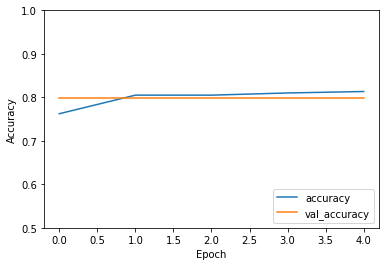

In [9]:
history = model.fit(X_train, Y_train, epochs=5, 
                    validation_data=(X_test, Y_test)) # just testing for now

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# evaluating our model on our test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)


# then export the model (build a pipeline)

# for inference on the zoom recording, just perform inference on representative frames
# (times 4 since you're dividing each frame into four quarters) and average for each person


In [10]:
model.save('/content/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/assets


In [11]:
model.save("model.h5")


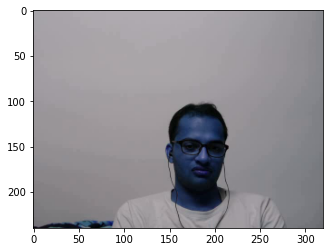

[[0.28260732 0.7734469  0.06115547 0.03885174]]
[0.33333333 1.         0.         0.        ]
<class 'numpy.ndarray'>
[0.28260732 0.7734469  0.06115547 0.03885174]


In [22]:
frame = X_test[0]
prediction = model.predict(np.array([frame,]))
plt.imshow(X_test[0])
plt.show()
print(prediction)
print(Y_test[0])
print(type(prediction))
print(prediction[0])


## Pipeline Stuff

In [34]:
# function for inference after loading the model
def predict(frame): # frame should be a numpy array in the shape (240, 320, 3)
  prediction = model.predict(np.array([frame,]))
  prediction = prediction * 3
  engagement_score = prediction[0][1] - prediction[0][0]
  stress_score = prediction[0][2] + prediction[0][3] 
  print("Engagement: " + str(engagement_score))
  print("Stress: " + str(stress_score))
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  plt.imshow(frame)
  plt.show()
  return engagement_score, stress_score

# function to get frames from an opencv video 
def get_subjects(video_path, frame_rate):
  cap = cv2.VideoCapture(video_path)
  images_folder = "/content/"
  frame_list = []
  frameRate = cap.get(frame_rate) #frame rate (adjust as needed)
  while(cap.isOpened()):
      frameId = cap.get(1) #current frame number
      ret, frame = cap.read()
      if (ret != True):
          break
      if (frameId % math.floor(frameRate) == 0):
          filename = images_folder + "/image_" +  str(int(frameId)) + ".jpg"
          frame_list.append(frame)
    
  cap.release()
  return frame_list

def divide_four(frame_list): 
  tl = []
  tr = []
  bl = []
  br = []
  for frame in frame_list:
    height, width = frame.shape[0], frame.shape[1]
    top_left = frame[0:int(-height/2), 0:int(width/2)]
    top_right = frame[0:int(-height/2), int(width/2):width]
    bottom_left = frame[int(-height/2):height, 0:int(width/2)]
    bottom_right = frame[int(-height/2):height, int(width/2):width]
    tl.append(top_left)
    tr.append(top_right)
    bl.append(bottom_left)
    br.append(bottom_right)
  return [tl, tr, bl, br] 

def resize(frame):
  return cv2.resize(frame, (320, 240))